# Converting SSD Mobilenet from Tensorflow to ONNX

Tensorflow has a large selection of pre-trained ssd models in its [object detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md).

This tutorial shows how to convert them to ONNX and run them under [onnxruntime](https://github.com/microsoft/onnxruntime).


We use [ssd_mobilenet_v1_coco](http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz) as example in this tutorial. Other models should work as well.

ONNX has support for various ops needed for SSD models since opset-10 so you'll need to use onnx-1.5 or better and a runtime that supports opset-10.

For this tutorial use used the following versions:
```
python 3.7
tensorflow: 1.13.1
onnx: 1.5.1
tf2onnx: 1.5.1
onnxruntime: 0.4
```

## Define some environment variables
Before we start, lets setup some variables where to find things.

In [1]:
import os
import sys

ROOT = os.getcwd()
WORK = os.path.join(ROOT, "work")
MODEL = "ssd_mobilenet_v1_coco_2018_01_28"
os.makedirs(WORK, exist_ok=True)

# force tf2onnx to cpu
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['MODEL'] = MODEL
os.environ['WORK'] = WORK

Install tf2onnx and onnxruntime if needed.

In [2]:
!pip install --user -U tf2onnx
!pip install --user -U onnxruntime

## Download the pretrained ssd model

In [3]:
!cd $WORK; wget -q http://download.tensorflow.org/models/object_detection/$MODEL.tar.gz
!cd $WORK; tar zxvf $MODEL.tar.gz

ssd_mobilenet_v1_coco_2018_01_28/
ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.index
ssd_mobilenet_v1_coco_2018_01_28/checkpoint
ssd_mobilenet_v1_coco_2018_01_28/pipeline.config
ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.data-00000-of-00001
ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.meta
ssd_mobilenet_v1_coco_2018_01_28/saved_model/
ssd_mobilenet_v1_coco_2018_01_28/saved_model/saved_model.pb
ssd_mobilenet_v1_coco_2018_01_28/saved_model/variables/
ssd_mobilenet_v1_coco_2018_01_28/frozen_inference_graph.pb


## Convert the model to ONNX

Above you can see that the model comes as a frozen graph 'frozen_inference_graph.pb' and also as a saved_model. 
Both can be converted to ONNX. We want to show how to convert both formats. 

In both cases make sure you use the option ```--opset 10``` and ```--fold_const```.
The first will enable opset-10 and the second will help the converter with optimizations of transposes.

A look at the model shows inputs and outptus of this model:

In [4]:
!saved_model_cli show --dir $WORK/$MODEL/saved_model/ --tag_set serve  --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['inputs'] tensor_info:
      dtype: DT_UINT8
      shape: (-1, -1, -1, 3)
      name: image_tensor:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['detection_boxes'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 100, 4)
      name: detection_boxes:0
  outputs['detection_classes'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 100)
      name: detection_classes:0
  outputs['detection_scores'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 100)
      name: detection_scores:0
  outputs['num_detections'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: num_detections:0
Method name is: tensorflow/serving/predict


The input is a batch of images in ***NHWC*** format and the used data type it uint8.

Lets start with the ```saved_model``` since this is in most cases the best and prefered format to convert from.

In [5]:
!python -m tf2onnx.convert --opset 10 --fold_const --saved-model $WORK/$MODEL/saved_model --output $WORK/$MODEL.onnx

2019-06-14 15:56:14,992 - INFO - Using tensorflow=1.13.1, onnx=1.5.0, tf2onnx=1.5.1/0c735a
2019-06-14 15:56:14,992 - INFO - Using opset <onnx, 10>
2019-06-14 15:56:19,011 - WARNING - Cannot infer shape for Postprocessor/BatchMultiClassNonMaxSuppression/map/while/PadOrClipBoxList/cond/zeros: Postprocessor/BatchMultiClassNonMaxSuppression/map/while/PadOrClipBoxList/cond/zeros:0
2019-06-14 15:56:39,463 - INFO - 
2019-06-14 15:56:39,902 - INFO - Optimizing ONNX model
2019-06-14 15:57:00,062 - INFO - After optimization: Add -47 (337->290), Cast -2 (1302->1300), Const -20 (2076->2056), Gather +6 (554->560), Identity -78 (81->3), Mul -13 (319->306), Reshape -13 (326->313), Shape -1 (112->111), Transpose -81 (279->198), Unsqueeze -7 (441->434)
2019-06-14 15:57:01,059 - INFO - 
2019-06-14 15:57:01,060 - INFO - Successfully converted TensorFlow model /home/gs/tensorflow-onnx/tutorials/work/ssd_mobilenet_v1_coco_2018_01_28/saved_model to ONNX
2019-06-14 15:57:01,163 - INFO - ONNX model is saved a

If we want use the the ```frozen graph``` we need to specify inputs and outputs.

In [6]:
!python -m tf2onnx.convert --graphdef $WORK/$MODEL/frozen_inference_graph.pb --output $WORK/$MODEL.frozen.onnx \
    --fold_const --opset 10 \
    --inputs image_tensor:0 \
    --outputs num_detections:0,detection_boxes:0,detection_scores:0,detection_classes:0                    

2019-06-14 15:57:06,835 - INFO - Using tensorflow=1.13.1, onnx=1.5.0, tf2onnx=1.5.1/0c735a
2019-06-14 15:57:06,835 - INFO - Using opset <onnx, 10>
2019-06-14 15:57:10,660 - WARNING - Cannot infer shape for Postprocessor/BatchMultiClassNonMaxSuppression/map/while/PadOrClipBoxList/cond/zeros: Postprocessor/BatchMultiClassNonMaxSuppression/map/while/PadOrClipBoxList/cond/zeros:0
2019-06-14 15:57:30,845 - INFO - 
2019-06-14 15:57:31,416 - INFO - Optimizing ONNX model
2019-06-14 15:57:51,316 - INFO - After optimization: Add -47 (337->290), Cast -2 (1302->1300), Const -20 (2076->2056), Gather +6 (554->560), Identity -78 (81->3), Mul -13 (319->306), Reshape -13 (326->313), Shape -1 (112->111), Transpose -81 (279->198), Unsqueeze -7 (441->434)
2019-06-14 15:57:52,323 - INFO - 
2019-06-14 15:57:52,323 - INFO - Successfully converted TensorFlow model /home/gs/tensorflow-onnx/tutorials/work/ssd_mobilenet_v1_coco_2018_01_28/frozen_inference_graph.pb to ONNX
2019-06-14 15:57:52,423 - INFO - ONNX mo

## Run the ssd model under onnxruntime

This is in theory very easy but it ends up with more code than expected because we want to draw the detections into the original image so we can see if the results are correct.

The tensorflow object detection models have a nice API: given a batch of images they return 4 tensors as result.


```num_detections```:
the number of detections

```detection_boxes```: 
a list of bounding boxes. Each list item describes a box with top, left, bottom, right relative to the image size.

```detection_scores```: 
the score for each detection

```detection_classes```: 
the coco class for the detection

Lets download a sample image from coco:

In [7]:
!wget -q http://images.cocodataset.org/val2017/000000088462.jpg

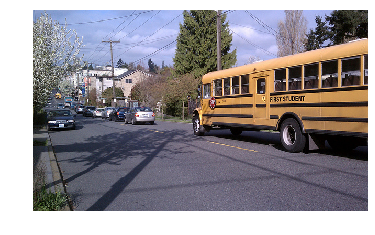

In [8]:
%matplotlib inline

import numpy as np
from PIL import Image, ImageDraw, ImageColor
import math
import matplotlib.pyplot as plt

img = Image.open("000000088462.jpg")
plt.axis('off')
plt.imshow(img)
plt.show()

This specific model model does not require fixed image dimension so no resize of the image is needed.

But we need to reshape the flat array returned by img.getdata() to HWC and than add an additial dimension to make NHWC, aka a batch of images with 1 image in it.

In [9]:
img_data = np.array(img.getdata()).reshape(img.size[1], img.size[0], 3)
img_data = np.expand_dims(img_data.astype(np.uint8), axis=0)
print(img_data.shape)

(1, 383, 640, 3)


A sanity check on the shape of img_data: width > height, 1 image and 3 colors seems to match our sample image. 

Now we can load the model and run the inference.

In [10]:
import onnxruntime as rt
sess = rt.InferenceSession(os.path.join(WORK, MODEL + ".onnx"))

# we want the outputs in this order
outputs = ["num_detections:0", "detection_boxes:0", "detection_scores:0", "detection_classes:0"]

In [11]:
result = sess.run(outputs, {"image_tensor:0": img_data})
num_detections, detection_boxes, detection_scores, detection_classes = result

In [12]:
# there are 8 detections
print(num_detections)

print(detection_classes)

[8.]
[[ 3.  3.  6.  3.  3.  3.  3. 10.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]


Looking at the results: num_detection is 8 so we found 8 objects. 
If we dump detection_classes we see that it returns a array of 100 items 
but since with num_detection being 8, only the first 8 items in the array are valid.

Now can draw the boxes into the image. The full list of classes can be found in the [coco dataset](http://cocodataset.org/). For the purpose of this tutorial we can to keep things simple and just define the classes we care about here:

In [13]:
coco_classes = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
}

def draw_detection(draw, d, c):
    """Draw box and label for 1 detection."""
    width, height = draw.im.size
    # the box is relative to the image size so we multiply with height and width to get pixels.
    top = d[0] * height
    left = d[1] * width
    bottom = d[2] * height
    right = d[3] * width
    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(height, np.floor(bottom + 0.5).astype('int32'))
    right = min(width, np.floor(right + 0.5).astype('int32'))
    label = coco_classes[c]
    label_size = draw.textsize(label)
    if top - label_size[1] >= 0:
        text_origin = tuple(np.array([left, top - label_size[1]]))
    else:
        text_origin = tuple(np.array([left, top + 1]))
    color = ImageColor.getrgb("red")
    thickness = 0
    draw.rectangle([left + thickness, top + thickness, right - thickness, bottom - thickness], outline=color)
    draw.text(text_origin, label, fill=color)  # , font=font)

The main loop over the results - each returned tensor is a batch but in the example we we used only 1 image.

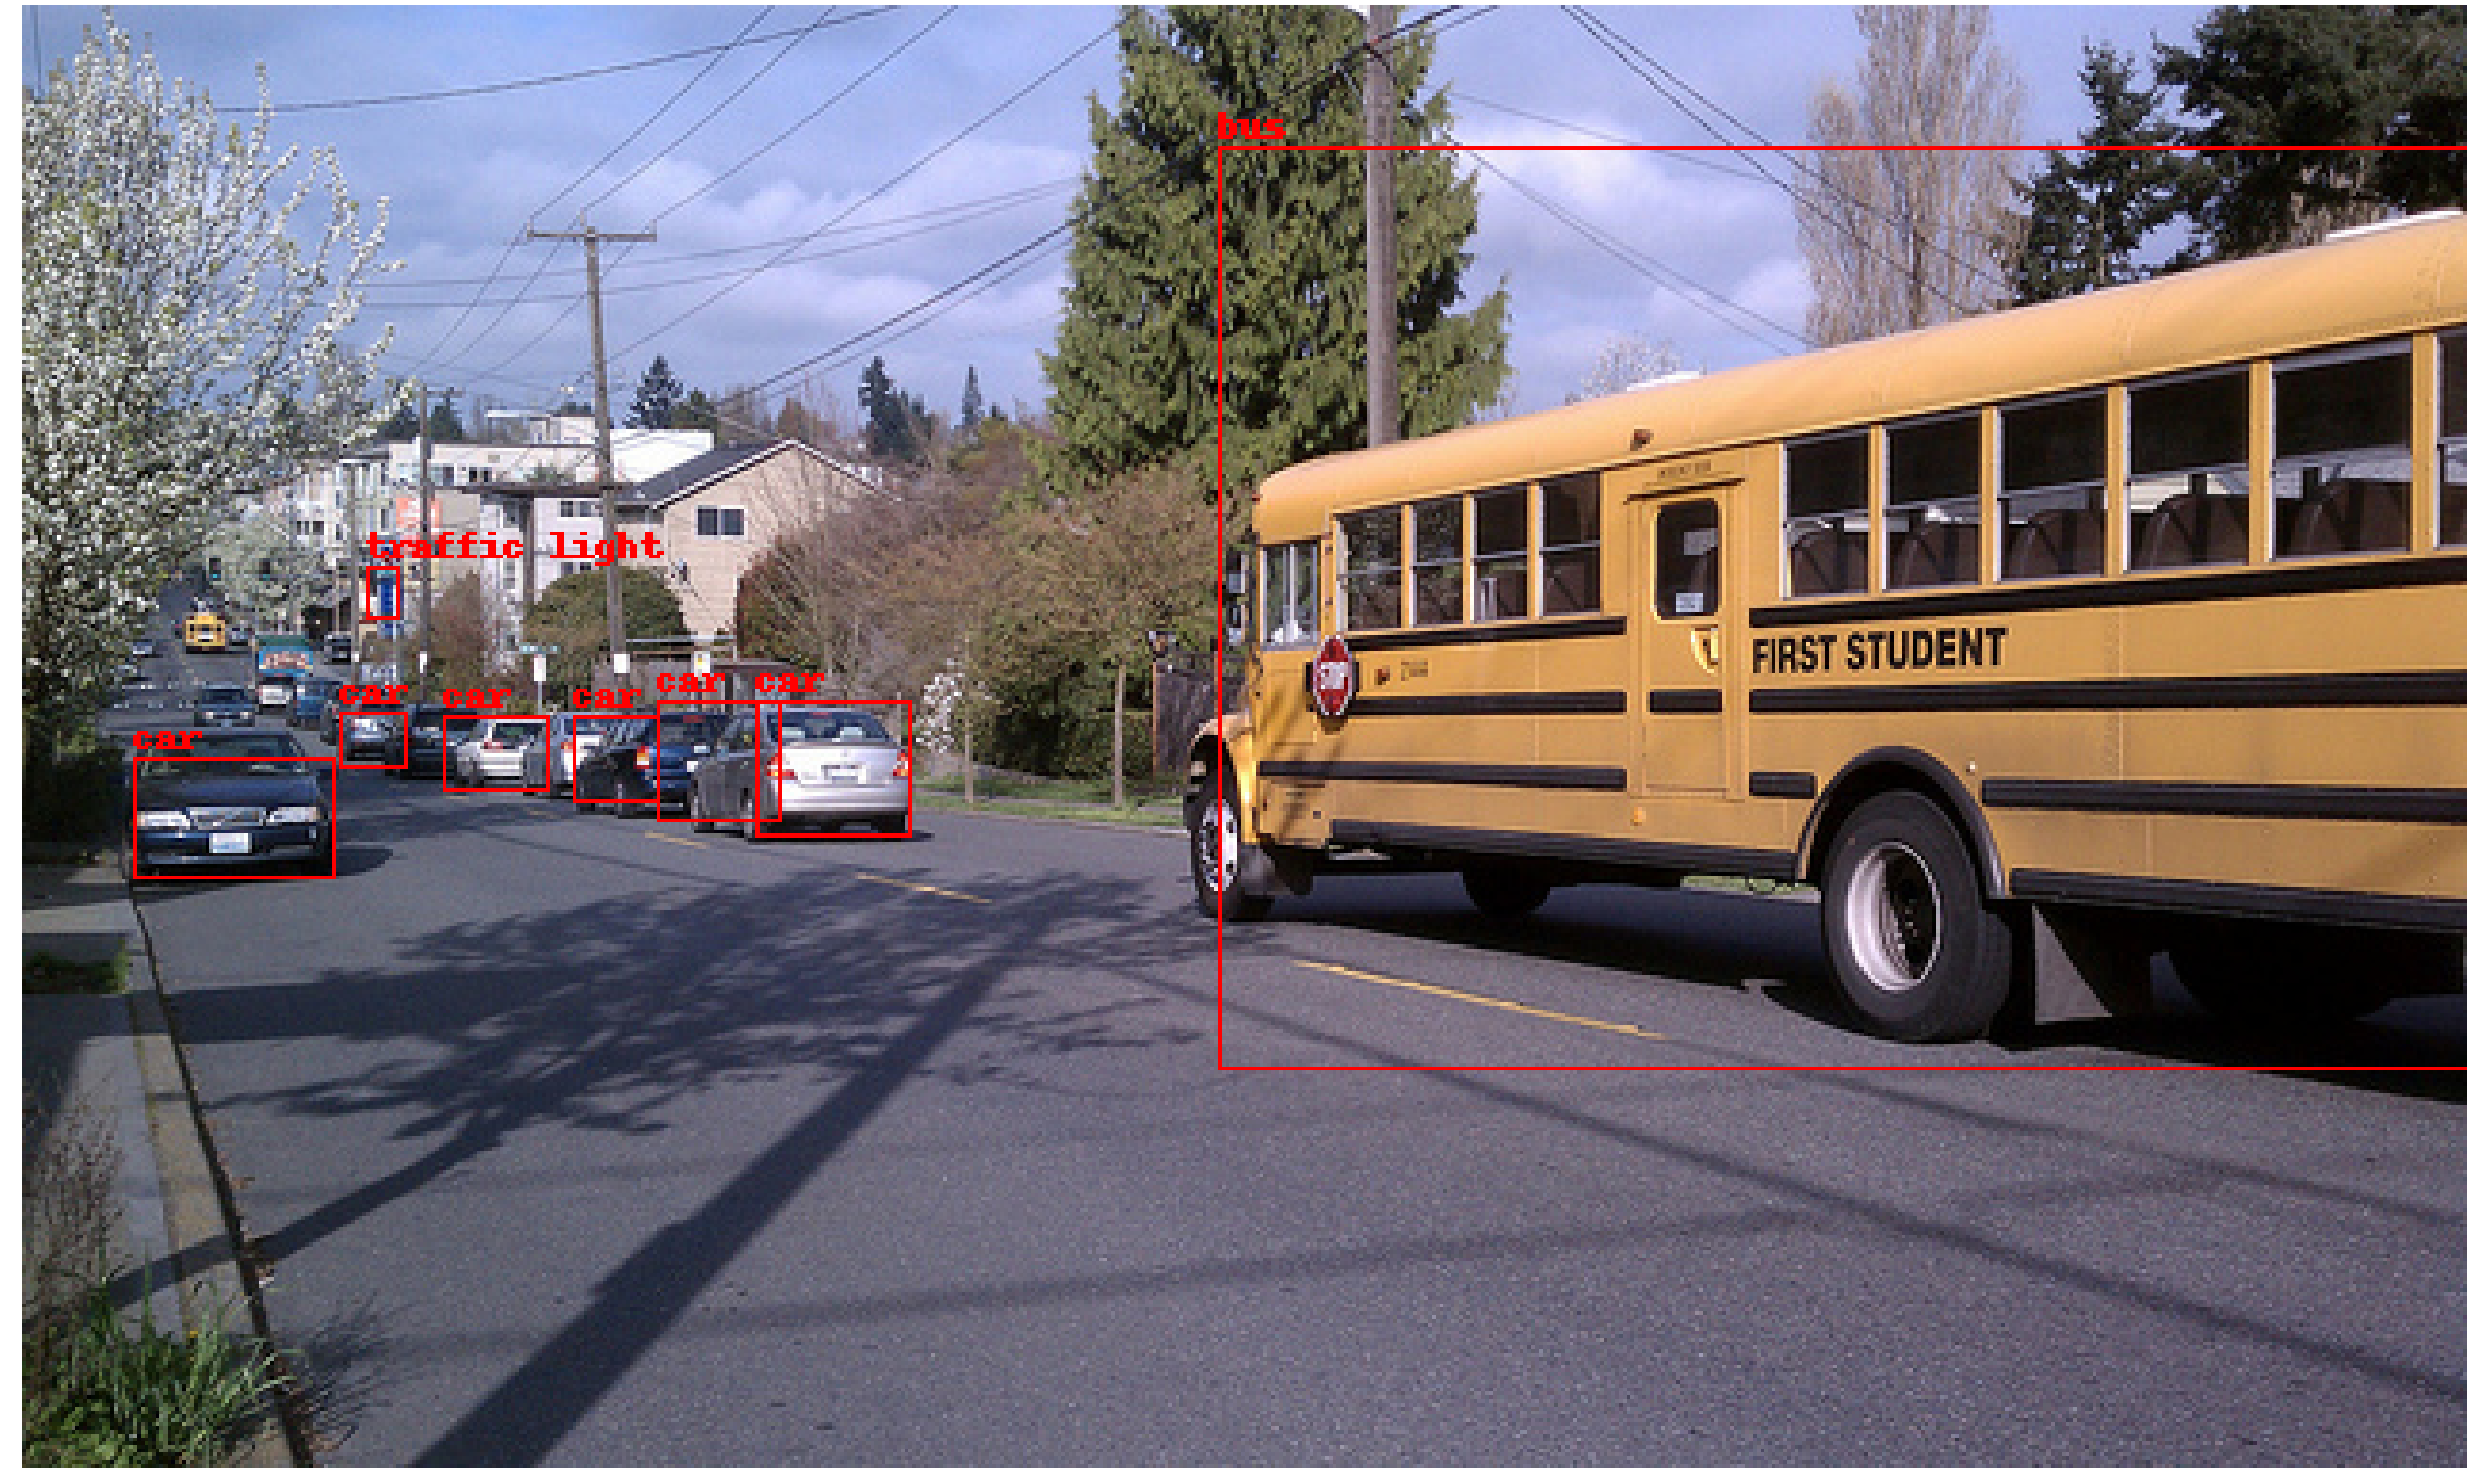

In [14]:
batch_size = num_detections.shape[0]
draw = ImageDraw.Draw(img)
for batch in range(0, batch_size):
    for detection in range(0, int(num_detections[batch])):
        c = detection_classes[batch][detection]
        d = detection_boxes[batch][detection]
        draw_detection(draw, d, c)

plt.figure(figsize=(80, 40))
plt.axis('off')
plt.imshow(img)
plt.show()

The entire process wasn't that hard and now you can run tensorflow object detection models under using ONNX.